## Training

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import os
import pandas as pd
import numpy as np
import tqdm.notebook as tq
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
data = pd.read_csv("Multi-Label Text Classification Dataset.csv")

df_data = proc_data = data.drop(["meshMajor","pmid","meshid","meshroot"], axis=1)

In [4]:
df_data = df_data.sample(n = 50000, random_state = 4)
# Dropping null row
df_data = df_data.dropna()

In [5]:
# Combine title and abstract to increase power
df_data["mixed"] = df_data["Title"] + ". " + df_data["abstractText"]
df_data.drop(columns=["abstractText", "Title"], axis=1, inplace=True)

In [6]:
df_data.head(3)

,A,B,C,D,E,F,G,H,I,J,L,M,N,Z,mixed
16477,1,1,1,0,1,0,0,0,0,0,0,1,1,0,Ocular findings in subacute sclerosing panence...
5969,1,1,0,1,0,0,1,0,0,0,1,0,0,0,Notch signaling suppresses IgH gene expression...
46459,0,1,1,1,1,0,1,0,0,0,0,0,1,0,Immunological and physiological effects of chr...


In [7]:
import re
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove punctuation and symbols
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Remove single characters
    text = ' '.join([word for word in text.split() if len(word) > 1])    
    return text


df_data["combined"] = df_data["mixed"].apply(clean_text)
df_data.drop(columns=["mixed"], axis=1, inplace=True)

df_data.head(2)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RISHU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,A,B,C,D,E,F,G,H,I,J,L,M,N,Z,combined
16477,1,1,1,0,1,0,0,0,0,0,0,1,1,0,ocular findings subacute sclerosing panencepha...
5969,1,1,0,1,0,0,1,0,0,0,1,0,0,0,notch signaling suppresses igh gene expression...


In [8]:
# split into train and test
df_train, df_test = train_test_split(df_data, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (34998, 15), Test: (7500, 15), Valid: (7500, 15)


In [9]:
# Hyperparameters
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # threshold for the sigmoid

In [10]:
from transformers import DistilBertTokenizer, DistilBertModel
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [11]:

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['combined'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
          'input_ids': inputs['input_ids'].flatten(),
          'attention_mask': inputs['attention_mask'].flatten(),
          'targets': torch.FloatTensor(self.targets[index]),
          'title': title
        }

In [12]:
target_list = list(df_data.columns)
target_list = target_list[:-1]

In [13]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)


# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [14]:
class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.2)
        self.classifier = torch.nn.Linear(768, 14)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = DistilBERTClass()
model.to(device)

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

In [15]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [16]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()


    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)


def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

In [17]:
data_dir = "D:\\Sem 2\\NLP\\Assignment_3\\task"

history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), os.path.join(data_dir,"output","trained_model.bin"))
        best_accuracy = val_acc


Epoch 1/3


  0%|          | 0/2188 [00:00<?, ?it/s]

train_loss=0.3507, val_loss=0.3002 train_acc=0.8521, val_acc=0.8747
Epoch 2/3


  0%|          | 0/2188 [00:00<?, ?it/s]

train_loss=0.2887, val_loss=0.2829 train_acc=0.8799, val_acc=0.8810
Epoch 3/3


  0%|          | 0/2188 [00:00<?, ?it/s]

train_loss=0.2661, val_loss=0.2756 train_acc=0.8897, val_acc=0.8843


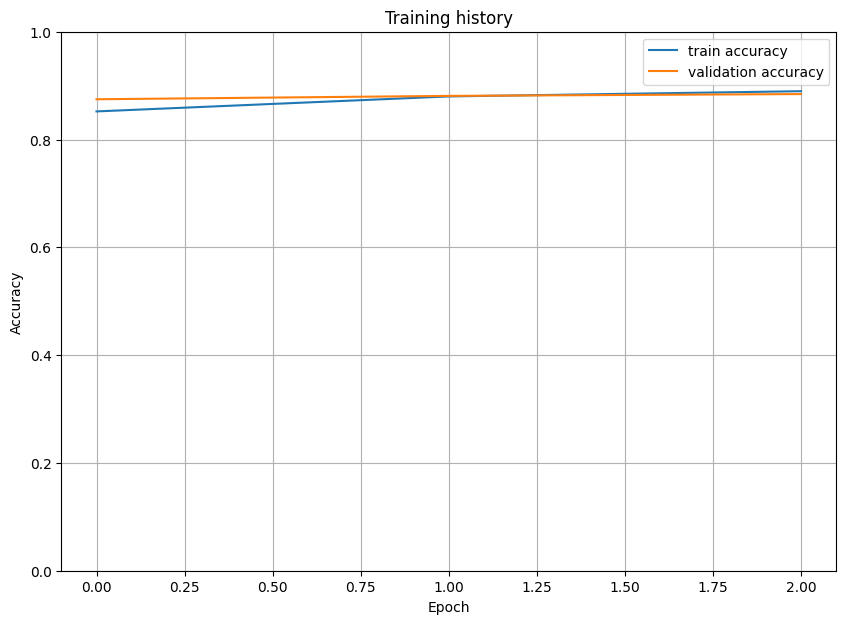

In [18]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()